# U.S. Domestic Flights Data Exploration

This project explores more than 7 million U.S. domestic flights for the entire year of 2019.

In [1]:
# Import all libraries needed for analysis

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Gathering
The dataset was sourced from Bureau of Transportation Statistics from January to Decemnber 2019.

In [2]:
# There are 12 separate CSV files downloaded, one for each month.

path = os.getcwd() +'\\Flights\\2019' # assign the correct directory where downloaded files were stored
all_files = glob.glob(os.path.join(path, '*.csv')) # use glob and os libraries to programatically load all files

df = (pd.read_csv(f) for f in all_files) # use pandas and for loop to read all files
df = pd.concat(df, ignore_index=True) # concatenate all files into one dataframe

In [3]:
df.head(5)

,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,Unnamed: 13
0,2019-01-01,3280,GNV,"Gainesville, FL",Florida,ATL,"Atlanta, GA",Georgia,600,1.0,723,0.0,0.0,NaN
1,2019-01-01,3281,MSP,"Minneapolis, MN",Minnesota,CVG,"Cincinnati, OH",Kentucky,1404,0.0,1709,0.0,0.0,NaN
2,2019-01-01,3282,DTW,"Detroit, MI",Michigan,CVG,"Cincinnati, OH",Kentucky,1220,0.0,1345,0.0,0.0,NaN
3,2019-01-01,3283,TLH,"Tallahassee, FL",Florida,ATL,"Atlanta, GA",Georgia,1527,0.0,1639,0.0,0.0,NaN
4,2019-01-01,3284,ATL,"Atlanta, GA",Georgia,FSM,"Fort Smith, AR",Arkansas,1902,0.0,2005,0.0,0.0,NaN


In [4]:
# Rename columns

columns = ['flight_date', 'flight_number', 'origin', 'origin_location',
       'origin_state', 'destination', 'destination_location', 'destination_state',
       'scheduled_departure', 'depart_delayed_time', 'scheduled_arrival', 'arrival_delayed_time',
       'cancelled', 'drop']

df.columns = columns

### Add Airport Information
Only the airport code is included in the downloaded file. Full name of the airport would be a great feature to add. The source also provides a CSV file of airport names with corresponding code.

In [5]:
# Load the dataset

airport = pd.read_csv('L_AIRPORT.csv_')

In [6]:
airport['Description'] = [x.partition(':')[-1].strip() for x in airport.Description]

In [7]:
# merge the name of airport of origin to df

df = df.merge(airport, how='left', left_on='origin', right_on = 'Code')

In [8]:
# rename new column

df.drop('Code', axis=1, inplace=True)
df.rename(columns={'Description':'origin_airport_name'}, inplace=True)

In [9]:
# merge the name of airport of destination to df

df = df.merge(airport, how='left', left_on='destination', right_on = 'Code')

In [10]:
df.drop('Code', axis=1, inplace=True)
df.rename(columns={'Description':'destination_airport_name'}, inplace=True)

### Check all States

In [11]:
states = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
          'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania', 
          'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 
          'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota', 'Delaware', 
          'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 
          'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 
         'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas', 'Arizona', 'Colorado', 
          'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah','Wyoming', 'Alaska', 'California', 
          'Hawaii', 'Oregon', 'Washington']

In [12]:
# check which values are not included in states

list(set(list(df.destination_state.unique())) - set(states))

['U.S. Virgin Islands',
 'Puerto Rico',
 'U.S. Pacific Trust Territories and Possessions']

In [13]:
# Since the analysis focuses on the 51 States, the values above will be dropped 
# Filter all rows with arrivals and destination in Puerto Rico', U.S. Virgin Islands, and
# U.S. Pacific Trust Territories and Possessions and assign to a variable

drop_rows = df[(df.origin_state == 'Puerto Rico') | 
               (df.origin_state == 'U.S. Virgin Islands') | 
               (df.origin_state == 'U.S. Pacific Trust Territories and Possessions') |
               (df.destination_state == 'Puerto Rico') | 
               (df.destination_state == 'U.S. Virgin Islands') | 
               (df.destination_state == 'U.S. Pacific Trust Territories and Possessions')].index

In [14]:
# Drop rows

df.drop(drop_rows, inplace=True)

### Region by State
Another useful variable to add is the region of U.S. states. This will be valuable when clustering our data later on.

In [15]:
# Create list of States with corresponding Region

Northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
             'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania']
Midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 
           'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
South = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 
         'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 
         'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
West = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah','Wyoming', 
        'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

In [16]:
# Create a dictionary for the list

state_dict = {}
region_dict = {'Northeast':Northeast, 'Midwest':Midwest, 'South':South, 'West':West}        

In [17]:
# Use for loop to create a dictionary where state is the key and region is value

for key, region in region_dict.items():
    for state in region:
        state_dict.update({state:key})

In [18]:
# Add the created list to the master dataset

origin_region = [state_dict[x] for x in df['origin_state']]
destination_region = [state_dict[x] for x in df['destination_state']]

df['origin_region'] = origin_region
df['destination_region'] = destination_region

## Data Wrangling

In [19]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7352434 entries, 0 to 7422036
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   flight_date               7352434 non-null  object 
 1   flight_number             7352434 non-null  int64  
 2   origin                    7352434 non-null  object 
 3   origin_location           7352434 non-null  object 
 4   origin_state              7352434 non-null  object 
 5   destination               7352434 non-null  object 
 6   destination_location      7352434 non-null  object 
 7   destination_state         7352434 non-null  object 
 8   scheduled_departure       7352434 non-null  int64  
 9   depart_delayed_time       7222855 non-null  float64
 10  scheduled_arrival         7352434 non-null  int64  
 11  arrival_delayed_time      7199362 non-null  float64
 12  cancelled                 7352434 non-null  float64
 13  drop                      0

In [20]:
# Descriptive statistics for all numeric value

df.describe()

,flight_number,scheduled_departure,depart_delayed_time,scheduled_arrival,arrival_delayed_time,cancelled,drop
count,7.352434e+06,7.352434e+06,7.222855e+06,7.352434e+06,7.199362e+06,7.352434e+06,0.0
mean,2.569439e+03,1.330794e+03,1.408346e+01,1.487240e+03,1.415186e+01,1.827585e-02,NaN
std,1.801073e+03,4.922110e+02,4.785842e+01,5.202445e+02,4.761519e+01,1.339472e-01,NaN
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,1.039000e+03,9.140000e+02,0.000000e+00,1.100000e+03,0.000000e+00,0.000000e+00,NaN
50%,2.173000e+03,1.322000e+03,0.000000e+00,1.515000e+03,0.000000e+00,0.000000e+00,NaN
75%,3.938000e+03,1.737000e+03,7.000000e+00,1.922000e+03,7.000000e+00,0.000000e+00,NaN
max,7.933000e+03,2.359000e+03,2.710000e+03,2.400000e+03,2.695000e+03,1.000000e+00,NaN


In [21]:
# Proportion of null values
null_arrivals = df.arrival_delayed_time.isnull().sum()/df.shape[0]
null_departures = df.depart_delayed_time.isnull().sum()/df.shape[0]

print(null_arrivals, null_departures)

0.020819228027072395 0.017623959630239456


In [22]:
# The proportion of null values is not significant so filling the null values with the median for columns 
# depart_delayed_time and arrival_delayed_time with zero is the best approach

df[['arrival_delayed_time', 'depart_delayed_time']] = df[['arrival_delayed_time', 'depart_delayed_time']].fillna(0)

In [23]:
# Convert data types for arrival_delayed_time, depart_delayed_time, cancelled to int

df[['arrival_delayed_time', 'depart_delayed_time', 'cancelled']] = df[['arrival_delayed_time', 'depart_delayed_time', 'cancelled']].astype(int)

In [24]:
# These columns will be dropped as it will not be usefull in this analysis

df.drop(['flight_number','drop','destination_location', 'origin_location', 'scheduled_departure', 
         'scheduled_arrival'], axis=1, inplace=True)

In [25]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7352434 entries, 0 to 7422036
Data columns (total 12 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   flight_date               7352434 non-null  object
 1   origin                    7352434 non-null  object
 2   origin_state              7352434 non-null  object
 3   destination               7352434 non-null  object
 4   destination_state         7352434 non-null  object
 5   depart_delayed_time       7352434 non-null  int32 
 6   arrival_delayed_time      7352434 non-null  int32 
 7   cancelled                 7352434 non-null  int32 
 8   origin_airport_name       7352434 non-null  object
 9   destination_airport_name  7352434 non-null  object
 10  origin_region             7352434 non-null  object
 11  destination_region        7352434 non-null  object
dtypes: int32(3), object(9)
memory usage: 645.1+ MB


There are 7,352,434 flights (rows) with 12 features. There are only two numerical values, the delayed departure and arrival times. Identifying locations which delays in departures and arrivals have more occurences or have longer time periods are the main feature of interest in the dataset. The state, region of each airport for categorical variables, and the delay time for both departure and arrival will be valuable in this analysis.

In [65]:
df.origin.value_counts() + df.destination.value_counts()

ABE    10026
ABI     4544
ABQ    47467
ABR     1501
ABY     2010
       ...  
WYS      528
XNA    28268
XWA      416
YAK     1444
YUM     3839
Length: 352, dtype: int64

## EXPLORATORY DATA ANALYSIS

Let's take a look at the delayed times for both departure and arrival flights.

In [26]:
dep_delayed = df.depart_delayed_time != 0
arr_delayed = df.arrival_delayed_time != 0

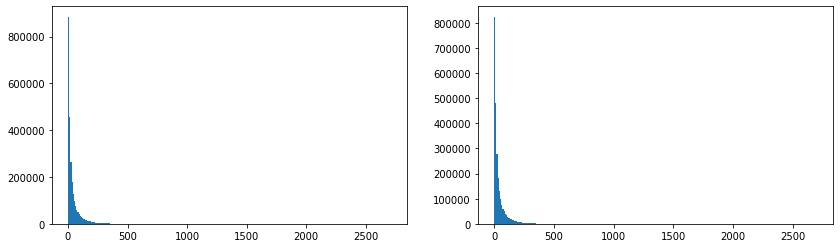

In [27]:
bin_dep = np.arange(0, df.depart_delayed_time[dep_delayed].max()+10, 10)
bin_arr = np.arange(0, df.arrival_delayed_time[arr_delayed].max()+10, 10)

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(14,4))
ax1.hist(df.depart_delayed_time[dep_delayed], bins=bin_dep)
ax2.hist(df.arrival_delayed_time[arr_delayed], bins=bin_arr)
plt.show()

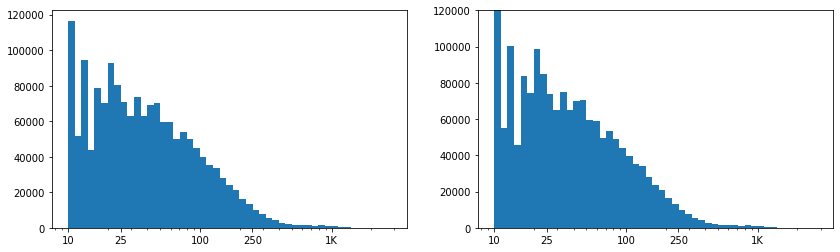

In [28]:
log_binsize = 0.05
bin_dep = 10** np.arange(1, np.log10(df.depart_delayed_time[dep_delayed].max())+log_binsize, log_binsize)
bin_arr = 10 ** np.arange(1, np.log10(df.arrival_delayed_time[arr_delayed].max())+log_binsize, log_binsize)

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(14,4))
ax1.hist(df.depart_delayed_time[dep_delayed], bins=bin_dep)
ax1.set_xscale('log')
ax1.set_xticks([10**1, 25, 10**2, 250, 10**3])
ax1.set_xticklabels(['10','25','100','250','1K'])
ax2.hist(df.arrival_delayed_time[arr_delayed], bins=bin_arr)
ax2.set_xscale('log')
ax2.set_xticks([10**1, 25, 10**2, 250, 10**3])
ax2.set_xticklabels(['10','25','100','250','1K'])
ax2.set_ylim(0,120000)
plt.show()

In [29]:
df[arr_delayed].arrival_delayed_time.mean()

41.15435246691293

The distribution of delayed times is extremely skewed to the right, with majority of flights having short delays. Both delayed times for departures and arrivals show similar distribution, even when plotted on a log-scale. Most delayed flights peak at around 10 minutes. Let's move on to our categorical variables for now.

### Region
**Number of Airports by Region**

In [30]:
airports_region = df.groupby(['origin_region','origin']).sum().reset_index()

In [31]:
airport_region_order = df.groupby(['origin_region','origin']).sum().reset_index().origin_region.value_counts().sort_values(ascending=False).index

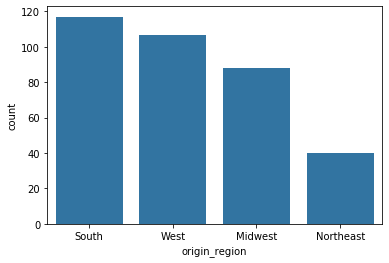

In [32]:
default_color = sns.color_palette()[0]

sns.countplot(data=airports_region, x='origin_region', color=default_color, order=airport_region_order)
plt.show()

**Number of Flights per Region**

In [33]:
# total number of  flights

total_dep_flights_by_region = df.origin_region.value_counts() # total departure flights
total_arr_flights_by_region = df.destination_region.value_counts() # total arrival flights
total_flights_by_region = total_dep_flights_by_region + total_arr_flights_by_region

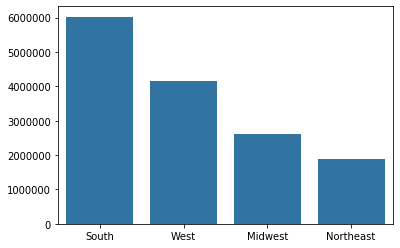

In [34]:
sns.barplot(x=total_flights_by_region.index, y=total_flights_by_region, color = default_color)
plt.show()

As expected, the most number of flights belong to the region with the most number of airports. Does one region have higher proportion of delayed flights than others? 

**Total Delayed Flights per Region**

In [35]:
df[dep_delayed].shape[0] / df.shape[0]

0.33929430716413095

In [36]:
total_delayed_flights = df[dep_delayed].origin_region.value_counts() + df[arr_delayed].origin_region.value_counts() 
total_delayed_flights

South        2050045
West         1420598
Midwest       871876
Northeast     627785
Name: origin_region, dtype: int64

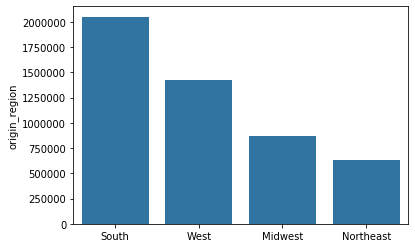

In [37]:
sns.barplot(x=total_delayed_flights.index, y=total_delayed_flights, color=default_color)
plt.show()

In [38]:
total_delayed_flights / total_flights_by_region

South        0.340141
West         0.340916
Midwest      0.332778
Northeast    0.332016
dtype: float64

The differences in percentage of delayed flights is minimal between regions. Approximately one-third of flights are delayed across the board. Which region has the longest delay in departures and arrivals? Let's include our quantitaive variable in the next analysis

**Total Average Delayed Time by Region**

In [39]:
ave_dep_delay_region = df[dep_delayed].groupby('origin_region').mean()['depart_delayed_time'].sort_values(ascending=False)
ave_arr_delay_region = df[arr_delayed].groupby('destination_region').mean()['arrival_delayed_time'].sort_values(ascending=False)

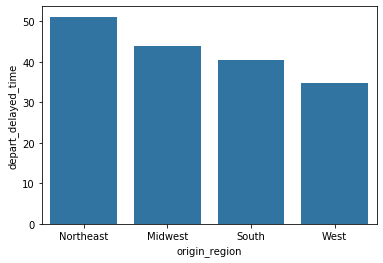

In [40]:
sns.barplot(x=ave_dep_delay_region.index, y=ave_dep_delay_region, color=default_color);

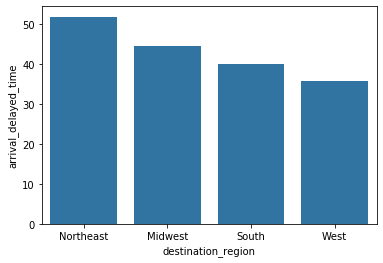

In [41]:
sns.barplot(x=ave_arr_delay_region.index, y=ave_arr_delay_region, color=default_color);

Interestingly, the region with the least number of airports and flights has the highest total average delay time. The Western region, second most number of flights and airports, has the least. To investigate more, we'll look at the relationship between region and delay times. 

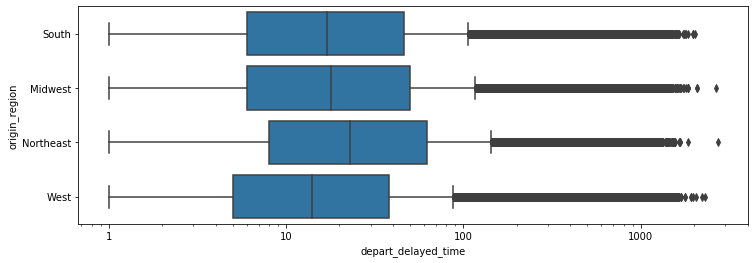

In [42]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df[dep_delayed], y='origin_region', x='depart_delayed_time', color=default_color)
plt.xscale('log')
plt.xticks([1, 10, 1e2, 1e3],['1','10','100','1000']);

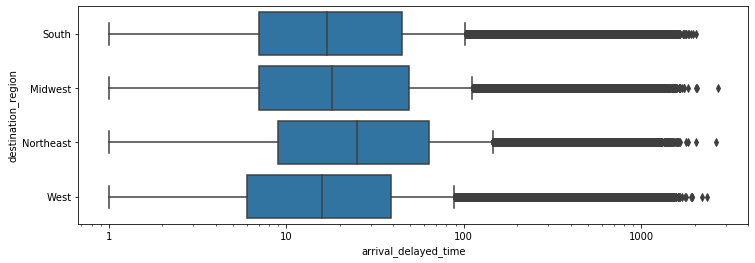

In [43]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df[arr_delayed], y='destination_region', x='arrival_delayed_time', color=default_color)
plt.xscale('log')
plt.xticks([1, 10, 1e2, 1e3],['1','10','100','1000']);

Since the delayed times are extremely skewed to the right, the boxplot shows the relationship of region and delayed times on a log-scale for both departures and arrival. The width of the IQR of all regions look similar but Northeast has higher IQR value. Its median is the highest among all regions, while West region has the least. South and Midwest regions look virtually identical.

We've determined that the region with the most number of airports houses the most flights. But on average, the region with the least number of airports have the longest time of delay. Since our feature, region, is too broad, our initial findings is not significant to determine which location have more occurences of delays. Let's expand our analysis by looking at numeric variables by **airports**.

I'll modify the dataset to reflect the average for all numeric values by grouping all categorical features and setting the index by airports. We'll create a separate dataset for arrivals and departures.

In [44]:
# Assign categorical columns to a variable for departures and arrivals

dep_columns = ['origin','origin_airport_name','origin_state','origin_region']
arr_columns = ['destination', 'destination_airport_name','destination_state', 'destination_region']

In [45]:
# Group data by categorical columns and use .mean() method for numerical values
# .reset_index() will set the index to columns

df_departures = df[dep_delayed].groupby(dep_columns).mean()['depart_delayed_time'].reset_index()
df_arrivals = df[arr_delayed].groupby(arr_columns).mean()['arrival_delayed_time'].reset_index()

In [46]:
# Set airport as index

df_departures.set_index('origin', inplace=True)
df_arrivals.set_index('destination', inplace=True)

In [47]:
columns = ['airport_name','state','region','delayed_time']

In [48]:
# Update column names

df_departures.columns = columns
df_arrivals.columns = columns

We have previously identified the number of airports, flights and delayed flights for each region so let's move on to the numeric variable in our new datasets.


**Total Average Delayed Time by Airport**

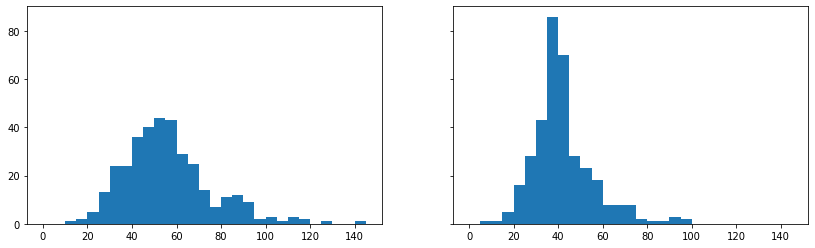

In [49]:
# Total Average Time of Delayed Departures

dep_bins = np.arange(0, df_departures.delayed_time.max()+5, 5)
arr_bins = np.arange(0, df_arrivals.delayed_time.max()+5, 5)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4), sharey=True, sharex=True)
ax1.hist(data=df_departures, x='delayed_time', bins=dep_bins)
ax2.hist(data=df_arrivals, x='delayed_time', bins=arr_bins)
plt.show()

The distributions of average delay times for both departures and arrivals is right-skewed having almost the same volume of flights on the lower end of the observation. However, the delayed time for departures are longer with data concentrated at around 50-60 minutes, and reaches at 140 minutes at the maximum. Arrivals have shorter delays with a peak at approximately 40 minutes and its longest at 100 minutes.

Now let's see which region has the highest average delay time by airport.

**Total Average Delayed Time by Airport Grouped by Region**

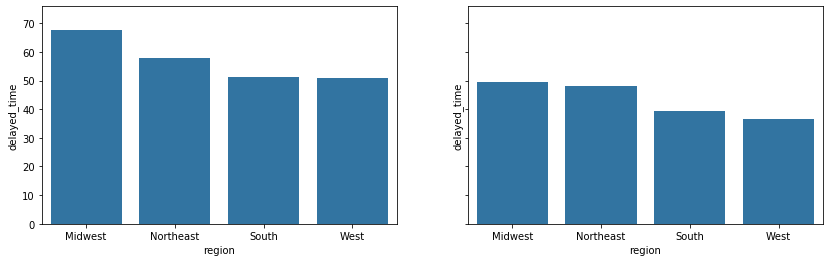

In [50]:
dep_order = df_departures.groupby('region').mean().index
arr_order = df_arrivals.groupby('region').mean().index

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4), sharey=True, sharex=True)
sns.barplot(data=df_departures, x='region', y='delayed_time', color=default_color, 
            order=dep_order, errwidth=0, ax=ax1)
sns.barplot(data=df_arrivals, x='region', y='delayed_time', color=default_color, 
            order=arr_order, errwidth=0, ax=ax2);

Interestingly, airports in the the Midwest region have the longest delay times for departures and arrivals. For departures, South and West have shorter delays and have average delay time just above 50 minutes. On the other hand, average delay times for arrivals in Midwest and Northeast, which have the longest delay times, are just below 50 minutes.

How many flights for each airport were delayed by more than the average? Let's get the average for both departures and arrivals, then filter our original dataset to get delayed flights with delay times greater than the average.

In [51]:
print('Average Total Delay Time of Airports')
print('Departures: ' + str(df_departures.delayed_time.mean()))
print('Arrivals: ' + str(df_arrivals.delayed_time.mean()))

Average Total Delay Time of Airports
Departures: 55.973334168148305
Arrivals: 42.157227310019195


Since the averages are close to 60 minutes or 1 hour, I'll use it as the baseline so it's easier to understand.

**Total Average Delay Time vs. % Flights Delayed > 1 Hour**

In [71]:
dep_flights_greater = df.origin[df.depart_delayed_time > 60].value_counts()
arr_flights_greater = df.destination[df.arrival_delayed_time > 60].value_counts()

In [72]:
dep_delayed_flights = df[dep_delayed].origin.value_counts()
arr_delayed_flights = df[arr_delayed].destination.value_counts()

In [73]:
pct_dep_greater = dep_flights_greater / dep_delayed_flights
pct_arr_greater = arr_flights_greater / arr_delayed_flights

In [79]:
pct_arr_greater

ABE    0.204487
ABI    0.117117
ABQ    0.142939
ABR    0.234899
ABY    0.198675
         ...   
WYS    0.067797
XNA    0.183562
XWA    0.312500
YAK    0.066929
YUM    0.143511
Name: destination, Length: 352, dtype: float64

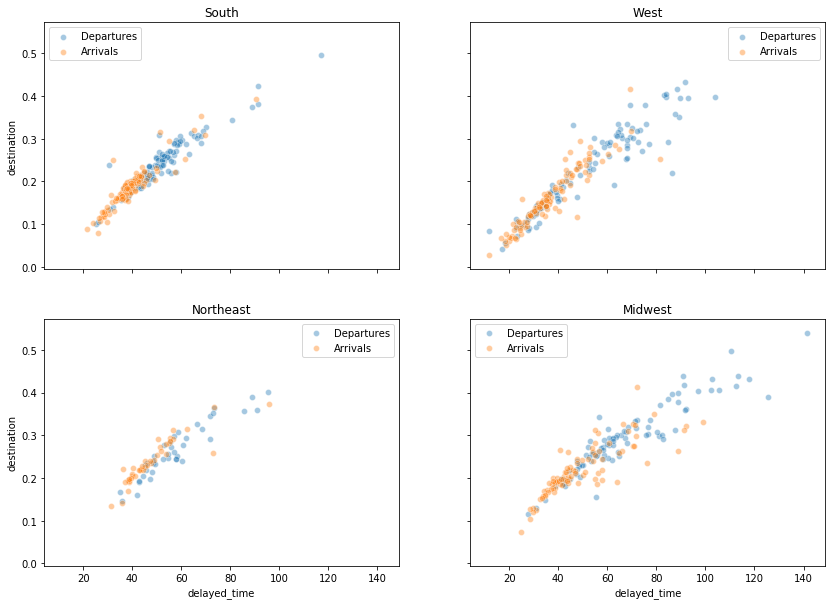

In [80]:
regions = ['South', 'West','Northeast','Midwest']

fig, ax = plt.subplots(2,2, figsize=(14, 10), sharey=True, sharex=True)
ax = ax.flatten()

for i, region in enumerate(regions):
    sns.scatterplot(data = df_departures[df_departures.region == region],
                    x = 'delayed_time', y = pct_dep_greater, ax=ax[i], alpha=0.4, label='Departures')
    sns.scatterplot(data = df_arrivals[df_arrivals.region == region],
                    x = 'delayed_time', y = pct_arr_greater, ax=ax[i], alpha=0.4, label='Arrivals')
    ax[i].set_title(region)
plt.show()

Airports in the South region have the least variability among the other regions with average delay times around 30-60 minutes and 20-30% of flights delayed by more than 1 hour. While having the shortest average delay time and lowest proportion, airports in the West region have more variability than South, around 20-60 minutes average delay time, with concentration in the lower-left of the scatter plot. The Northeast region has lesser variability in both average delay time and proportion of flights delayed by more than 1 hour, but on a higher range. Furthermore, despite having the fewest airports, plotted points are not as concentrated as with the South and West regions. Lastly, departure flights in the Midwest region have longer delay times and have longer flight delays.

**Total Average Delay Time vs. % Flights Delayed +1 Hour vs. Total Number of Flights**

In [67]:
df.origin.value_counts()

ATL    393032
ORD    338839
DFW    303959
DEN    252026
CLT    234519
        ...  
HYA        83
GST        82
DLG        82
PGV        80
AKN        61
Name: origin, Length: 352, dtype: int64

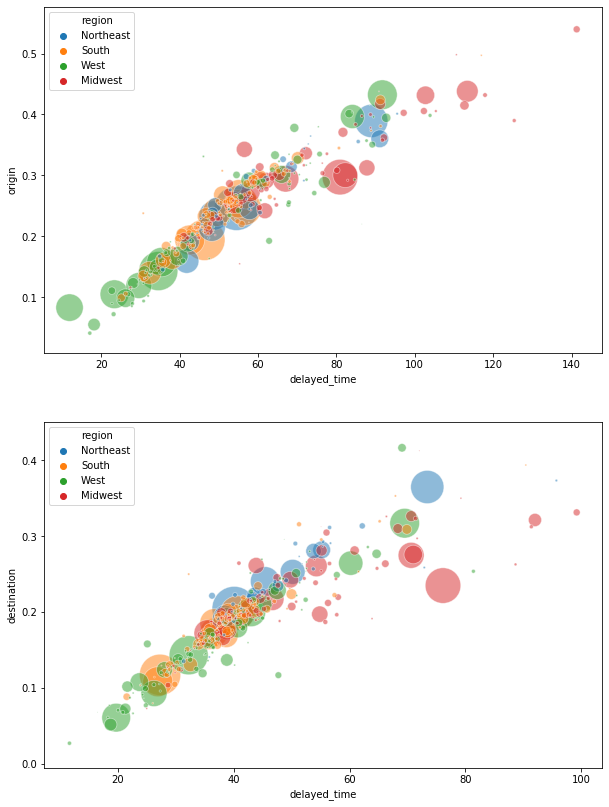

In [78]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,14))

sns.scatterplot(data=df_departures, x='delayed_time', y=pct_dep_greater, hue='region', 
                s=df.origin.value_counts()/200, alpha=0.5, ax=ax1)
sns.scatterplot(data=df_arrivals, x='delayed_time', y=pct_arr_greater, hue='region', 
                s=df.destination.value_counts()/200, alpha=0.5, ax=ax2)
plt.show()

Larger plot points are more mostly in the mid-lower left of the scatter plot which shows an extremely slight inverse relationship between the total number of flights and delayed times.

## CONCLUSION

Grouping the data by airport then clustered into region proved to be most helpful in this analysis. The distribution of delay times in both departures and arrivals shows a right-skewed distribution with most of the data are in the lower end of the observation. In general, arriving flights have shorter delay time compared to departures. The average flight delay time of each airport varies across the four regions of the U.S. Airports in the Southern and Western regions have shorter average delay time, and South and Northeast have fewer flights with long delays. While having the shortest average delay time, there are few airports in the Western region have higher percentages of flights having long delays. On the other hand, Midwest has the most number of airports with long average delay time and more flights with delay time of more than one hour.

Lastly, the number of total flights and total average delay time for each airport shows a very slight negative relationship. Having more flights tends to have shorter average delay time, and fewer flights with long delays.

## REFERENCES:
- https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
- https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT
- https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States
- https://www.visualcapitalist.com/visualizing-the-u-s-airports-with-the-worst-flight-delays/